## 1. Установка библиотек и знакомство с данными

In [ ]:
!pip install wget
!pip install catboost
!pip install unrar
!pip install patool
!pip install pyunpack

In [ ]:
import pandas as pd
import numpy as np
!wget --no-check-certificate --output-document example.rar https://github.com/dmitrykhrabroff/INID/blob/main/regulations.rar?raw=true



from pyunpack import Archive
Archive('/content/example.rar').extractall('/content/')




--2021-11-20 09:19:37--  https://github.com/dmitrykhrabroff/INID/blob/main/regulations.rar?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dmitrykhrabroff/INID/raw/main/regulations.rar [following]
--2021-11-20 09:19:38--  https://github.com/dmitrykhrabroff/INID/raw/main/regulations.rar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmitrykhrabroff/INID/main/regulations.rar [following]
--2021-11-20 09:19:38--  https://raw.githubusercontent.com/dmitrykhrabroff/INID/main/regulations.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting resp

In [ ]:
data = pd.read_csv('/content/regulations.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85006 entries, 0 to 85005
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  85006 non-null  int64  
 1   act_title                           85005 non-null  object 
 2   publication_date                    84417 non-null  object 
 3   developer                           84221 non-null  object 
 4   okved_list                          73097 non-null  object 
 5   views_num                           84417 non-null  float64
 6   comments_num                        84417 non-null  float64
 7   likes_num                           84417 non-null  float64
 8   dislikes_num                        84417 non-null  float64
 9   regulatory_impact                   84417 non-null  object 
 10  added_by                            84417 non-null  object 
 11  responsible                         81684

In [ ]:
!wget --no-check-certificate --output-document train_answer.csv https://raw.githubusercontent.com/dmitrykhrabroff/INID/main/train_answer.csv

train_answer = pd.read_csv('/content/train_answer.csv')
train_answer.shape

--2021-11-20 09:19:41--  https://raw.githubusercontent.com/dmitrykhrabroff/INID/main/train_answer.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 658574 (643K) [text/plain]
Saving to: ‘train_answer.csv’

train_answer.csv    100%[===================>] 643.14K  --.-KB/s    in 0.04s   

2021-11-20 09:19:41 (14.0 MB/s) - ‘train_answer.csv’ saved [658574/658574]



(81006, 2)

In [ ]:
not_null_in_col= dict()
for col in data.columns:
  not_null_in_col[col] = [sum(data[col].notnull()), sum(data[col].isna()),sum(data[col].notnull()) / data.shape[0]]
na_data = pd.DataFrame(not_null_in_col).T
na_data.columns = ['num_notna', 'num_na', 'proportion_na']
na_data.sort_values('proportion_na', ascending = False, inplace=True)
na_data

,num_notna,num_na,proportion_na
id,85006.0,0.0,1.000000
act_title,85005.0,1.0,0.999988
dislikes_num,84417.0,589.0,0.993071
mineco_solution,84417.0,589.0,0.993071
act_changes_controlling_activities,84417.0,589.0,0.993071
is_regionally_signigicant,84417.0,589.0,0.993071
regulatory_impact,84417.0,589.0,0.993071
added_by,84417.0,589.0,0.993071
likes_num,84417.0,589.0,0.993071
comments_num,84417.0,589.0,0.993071


## 2. Обработка пропущенных значений

Можем заметить, что в данных пристуствует много пропущенных значений, поэтому приступим к их обработке. Во первых мы видим, что для многих столбцов пропущенно ровно 589 значений, посмотрим, что это за данные.

In [ ]:
data.loc[data['publication_date'].isna(), :]

,id,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance
16195,23312,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16226,23374,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16834,24276,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16885,24351,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16919,24396,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76807,111048,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76811,111052,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76819,111062,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77909,112248,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Эти данные абсолютно не информативны, поэтому можем смело их удалить, чтобы они не портили модель.

In [ ]:
data = data.loc[data['publication_date'].notnull(), :]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84417 entries, 0 to 85005
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  84417 non-null  int64  
 1   act_title                           84416 non-null  object 
 2   publication_date                    84417 non-null  object 
 3   developer                           84221 non-null  object 
 4   okved_list                          73097 non-null  object 
 5   views_num                           84417 non-null  float64
 6   comments_num                        84417 non-null  float64
 7   likes_num                           84417 non-null  float64
 8   dislikes_num                        84417 non-null  float64
 9   regulatory_impact                   84417 non-null  object 
 10  added_by                            84417 non-null  object 
 11  responsible                         81684

В столбцах которых менее 20% пропущенных данных методом fillna() заменим пропущенные значения. А столбцы данных содержащие около 80% пропущенных значений заменим значения на 0 если данные пропущено, и 1 если данные есть.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

data['okved_list'].fillna('Не указан ОКВЭД', inplace = True)
data['responsible'] = data['responsible'].fillna('Нет ответственного')
data['developer'] = data['developer'].fillna('Нет ответственного')

In [ ]:
def mineco_to_int(x):
  if x == 'Не определено':
    return 0
  elif x == 'Положительное':
      return 1
  elif x == 'Отрицательное':
      return -1
  else:
    return -2
data['mineco_solution'] = data['mineco_solution'].apply(lambda x: mineco_to_int(x))
data['mineco_solution'].value_counts()

 0    76156
 1     5860
-1     2401
Name: mineco_solution, dtype: int64

In [ ]:
data['is_regionally_signigicant'] = data['is_regionally_signigicant'].astype('float32').astype('int')
data['is_regionally_signigicant'].value_counts()

0    83785
1      632
Name: is_regionally_signigicant, dtype: int64

In [ ]:
data['act_changes_controlling_activities'] = data['act_changes_controlling_activities'].astype('float32').astype('int')
data['act_changes_controlling_activities'].value_counts()

0    83360
1     1057
Name: act_changes_controlling_activities, dtype: int64

In [ ]:
def reg_impact_to_int(x):
  if x == 'Не определена':
    return 0
  elif x == 'Низкая':
      return 3
  elif x == 'Средняя':
      return 2
  elif x == 'Высокая':
      return 1
  else:
    return -1
data['regulatory_impact'].fillna(-1, inplace = True)
data['regulatory_impact'] = data['regulatory_impact'].apply(lambda x: reg_impact_to_int(x))
data['regulatory_impact'].value_counts()


0    57404
3    18105
2     6633
1     2275
Name: regulatory_impact, dtype: int64

In [ ]:
col_list = ['problem_addressed',	'act_objectives',	'persons_affected_by_act',	'relations_regulated_by_act',	'act_significance']
for col in col_list:
  data[col] = data[col].apply(lambda x: 1 if isinstance(x, str) else 0)

In [ ]:
data['act_title'].fillna('', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84417 entries, 0 to 85005
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  84417 non-null  int64  
 1   act_title                           84417 non-null  object 
 2   publication_date                    84417 non-null  object 
 3   developer                           84417 non-null  object 
 4   okved_list                          84417 non-null  object 
 5   views_num                           84417 non-null  float64
 6   comments_num                        84417 non-null  float64
 7   likes_num                           84417 non-null  float64
 8   dislikes_num                        84417 non-null  float64
 9   regulatory_impact                   84417 non-null  int64  
 10  added_by                            84417 non-null  object 
 11  responsible                         84417

Пропущенные значения успешно обработаны, перейдем к анализу данных

## 3. Анализ данных

In [ ]:
numeric_col = data.dtypes[data.dtypes == float].index
numeric_col

Index(['views_num', 'comments_num', 'likes_num', 'dislikes_num'], dtype='object')

# Рассмотрим распределение количественных признаков

In [ ]:
data[numeric_col].describe(percentiles=[.5])

,views_num,comments_num,likes_num,dislikes_num
count,84417.000000,84417.000000,84417.000000,84417.000000
mean,897.969343,1.131466,5.378384,10.661999
std,4379.055855,44.974321,1146.420189,1315.150542
min,7.000000,0.000000,0.000000,0.000000
50%,425.000000,0.000000,0.000000,0.000000
max,811307.000000,7961.000000,330855.000000,373140.000000


Мы видим, что распределение признаков далеко от нормального, значения медианы и среднего сильно отличаются. В среднем количество комментариев, лайков и дизлайков имеет значение не более 10, но случаются выбросы видимо в случае наиболее резонасных законопроектов.

Прологорифмируем наши количественные значения, чтобы приблизить распределение наших признаков к нормальному



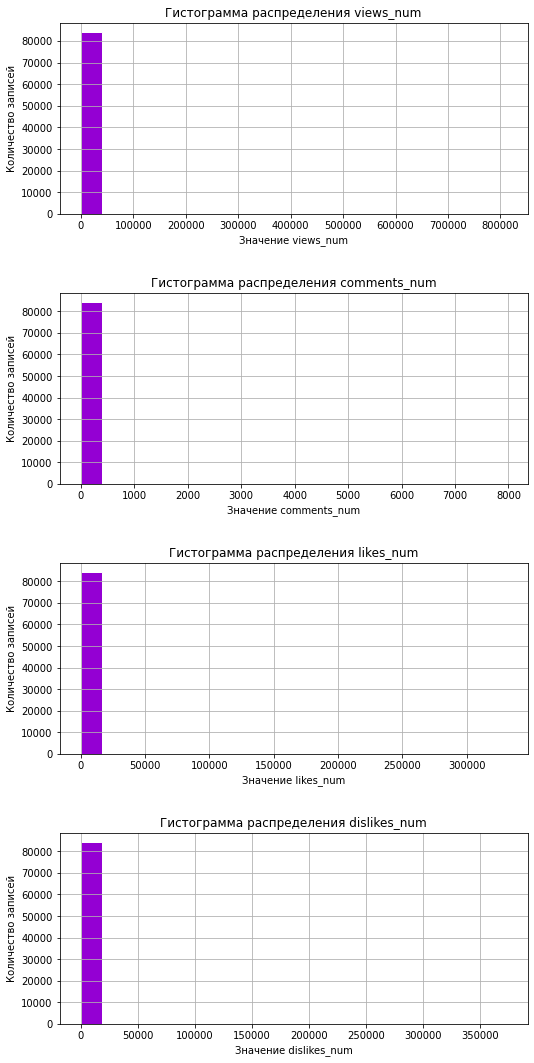

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(numeric_col),1)
fig.tight_layout(pad=0)
for i,num_col in enumerate(numeric_col):
  data[num_col].plot(kind='hist', bins=20, grid=True, ax = axes[i], figsize = (7,15),   color = 'darkviolet',  linewidth=1, edgecolor='w')
  axes[i].set_title('Гистограмма распределения {}'.format(num_col))
  axes[i].set_xlabel('Значение {}'.format(num_col))
  axes[i].set_ylabel('Количество записей')
  

In [ ]:
for col in numeric_col:
  data[col] = data[col].map(lambda x: x if x != 0 else 10**-5)
  data[col] = data[col].map(lambda x: np.log(x))


In [ ]:
data[numeric_col].describe(percentiles=[.5])

,views_num,comments_num,likes_num,dislikes_num
count,84417.000000,84417.000000,84417.000000,84417.000000
mean,6.204153,-10.706629,-9.902934,-9.842303
std,0.815698,3.132248,4.101301,4.269847
min,1.945910,-11.512925,-11.512925,-11.512925
50%,6.052089,-11.512925,-11.512925,-11.512925
max,13.606402,8.982310,12.709435,12.829709


KeyError: ignored

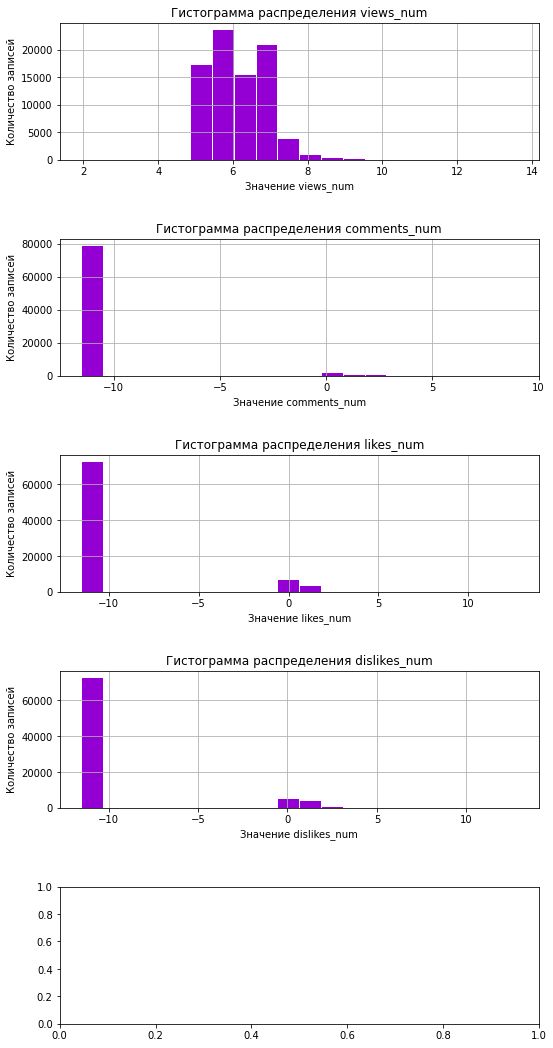

In [ ]:
fig, axes = plt.subplots(len(numeric_col),1)
fig.tight_layout(pad=0)
for i,num_col in enumerate(numeric_col):
  data[num_col].plot(kind='hist', bins=20, grid=True, ax = axes[i], figsize = (7,15),   color = 'darkviolet',  linewidth=1, edgecolor='w')
  axes[i].set_title('Гистограмма распределения {}'.format(num_col))
  axes[i].set_xlabel('Значение {}'.format(num_col))
  axes[i].set_ylabel('Количество записей')

## 4. Feature engineering

Объедим наши данные с признаками с метками правильных ответов. Будем использовать в дальнейшем для обучения

In [ ]:
new_data = pd.merge(data, train_answer, on = 'id',how = 'left')
new_data.head()

,id,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance,passed
0,5038,Об утверждении тарифов на услуги по транспорти...,2013-09-11,ФСТ России,Не указан ОКВЭД,5.929589,-11.512925,-11.512925,-11.512925,3,Митина Ольга Викторовна,Митина Ольга Викторовна,0,0,0,0,0,0,0,0,0.0
1,5039,О внесении изменений в отдельные законодательн...,2013-06-11,Минтруд России,Здравоохранение; Предоставление социальных услуг,6.222576,-11.512925,-11.512925,-11.512925,3,Рахов Виталий Сергеевич,Павлова Зоя Ивановна,0,0,0,0,0,0,0,0,0.0
2,5040,Об утверждении Положения об уведомлении лиц об...,2013-04-29,Росфинмониторинг,Финансовая деятельность,6.059123,-11.512925,-11.512925,-11.512925,3,Тимофеева Алёна Игоревна,Лях Валерий Владимирович,0,0,0,0,0,0,0,0,0.0
3,5041,О внесении изменений в Положение о Министерств...,2013-10-21,Минобрнауки России,Образование,5.929589,-11.512925,-11.512925,-11.512925,3,Вотоновская Ирина Вячеславовна,Михайлова Ирина Вячеславовна,0,0,0,0,0,0,0,0,1.0
4,5042,О внесении изменений в Правила подготовки и пр...,2014-02-24,Минприроды России,Не указан ОКВЭД,6.212606,-11.512925,-11.512925,-11.512925,3,Соболева Светлана Юрьевна,Соболева Светлана Юрьевна,0,0,0,1,1,1,1,1,NaN


Создадим новые признаки, год, месяц, и день недели. А так же комбинацию признаков год и месяц.

In [ ]:
new_data['publication_date'] = pd.to_datetime(new_data['publication_date'])
new_data['month'] = new_data['publication_date'].map(lambda x: x.month)
new_data['year'] = new_data['publication_date'].map(lambda x: x.year)
new_data['dayofweek'] = new_data['publication_date'].map(lambda x: x.weekday())
new_data['year_month'] = new_data[['year', 'month']].apply(lambda x: str(x.year) + '_' + str(x.month), axis = 1)

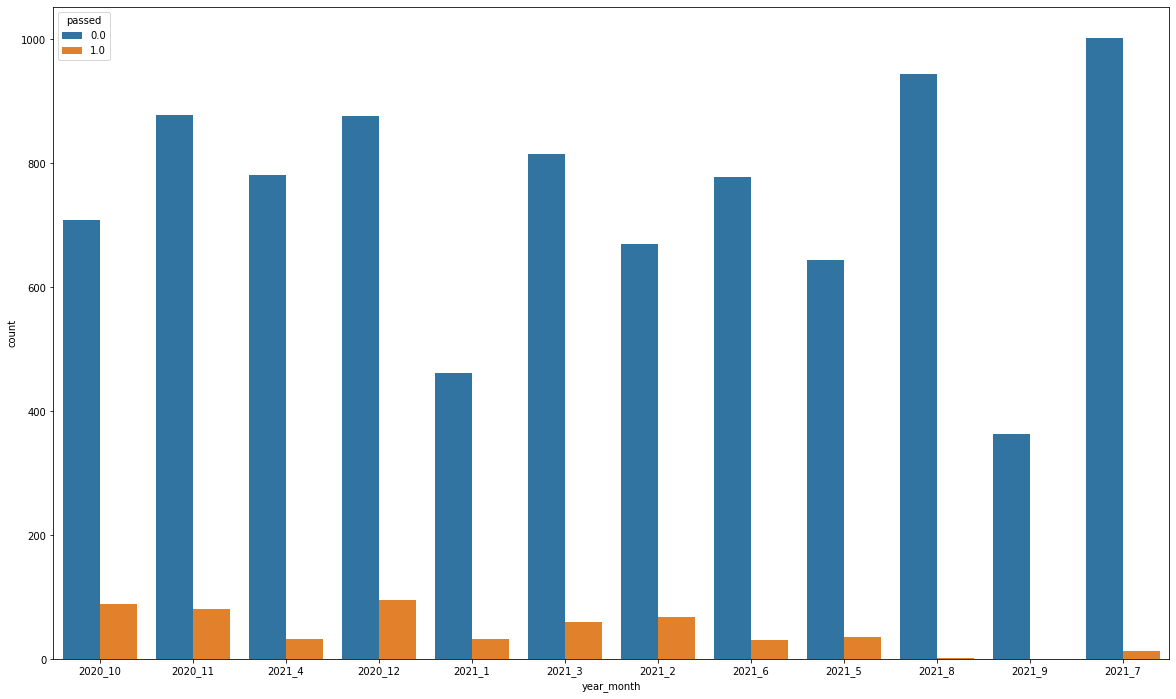

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,12))
sns.countplot(data = new_data.iloc[-10000:, :], x = 'year_month', hue = 'passed');


Мы видим, что отношение кол-ва принятых и не принятых законопроектов для каждой пары год_месяц существенно меняется



Сначала разобьем нашу выборку на тренировочную, тестовую и валидационную

In [ ]:
from sklearn.model_selection import train_test_split
train = new_data.loc[new_data['passed'].notnull(), :].drop(['publication_date','id','act_title'], axis = 1)
test = new_data.loc[new_data['passed'].isna(), :].drop(['publication_date','id','act_title'], axis = 1)


''

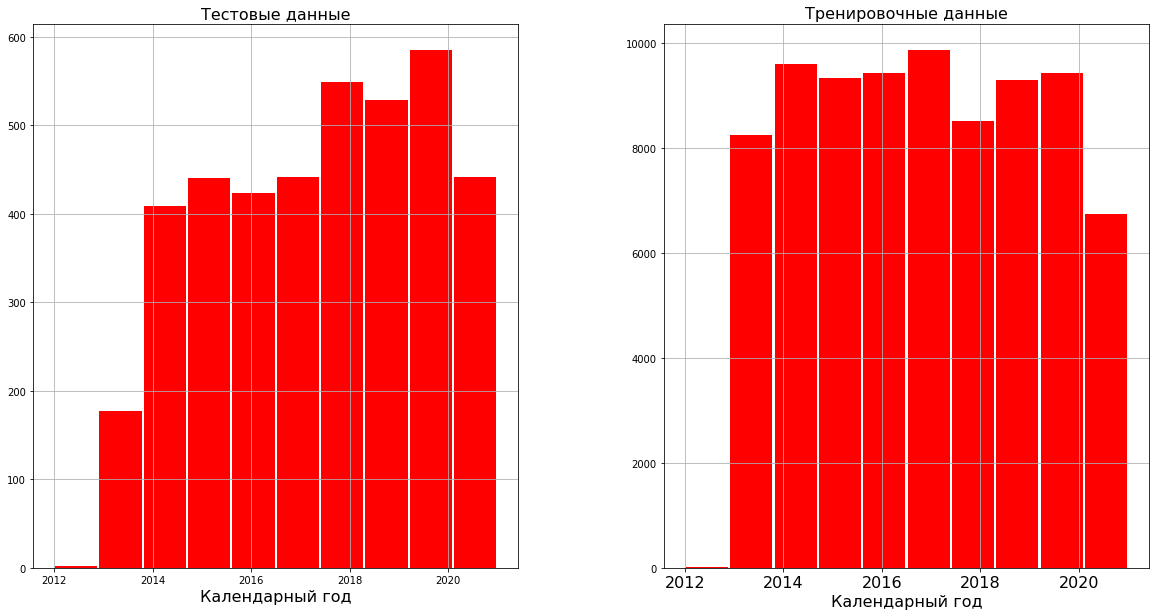

In [ ]:
fig, axes = plt.subplots(1,2)
new_data.loc[new_data['passed'].isna(),:].hist(column = 'year', ax = axes[0], bins = 10, color = 'r', range = (2012, 2021), rwidth = 0.95);
new_data.loc[new_data['passed'].notnull(),:].hist(column = 'year', ax = axes[1], bins=10, range = (2012, 2021), color = 'r', rwidth = 0.95);
fig.set_figheight(10)
fig.set_figwidth(20)
axes[0].set_xlabel('Календарный год', fontsize = 16)
axes[1].set_xlabel('Календарный год', fontsize = 16)
plt.xticks(fontsize = 16)
axes[0].set_title('Тестовые данные', fontsize = 16)
axes[1].set_title('Тренировочные данные', fontsize = 16);
;

Мы видим что в и в тренировочной и в тестовой выборке присутствуют данные с 2012 по 2021 год. Поэтому мы создадим признак, где каждой группе месяц_год будет соответствовать среднее отношение кол-ва принятых и не принятых законопроектов на тренировочной выборке.

In [ ]:
def cat_mean_feat(data, group_col, hue_col):
  mask = data.groupby(group_col)[hue_col].mean()
  
  return mask

new_data['mean_year_month'] = new_data['year_month'].map(cat_mean_feat(train, 'year_month', 'passed'))

Создадим признаки пол лица добавившего законопроект, пол лица отвественного за законопроект, и соотношение полов для конкретного законопроекта.
Для начала скачаем базу данных русских имен с репозитория, напишем функцию для установления пола, которая принимает значение 0 если это женщина, 1 если мужчина, и -1 в случае нестандартного имени либо ошибки заполнения, что тоже может служить признаком.

In [ ]:
!wget --no-check-certificate  https://raw.githubusercontent.com/dmitrykhrabroff/INID/79244768a76e8896b6b4981023e5c40c753f304f/russian_names.json


--2021-11-20 09:19:51--  https://raw.githubusercontent.com/dmitrykhrabroff/INID/79244768a76e8896b6b4981023e5c40c753f304f/russian_names.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6773278 (6.5M) [text/plain]
Saving to: ‘russian_names.json.8’

russian_names.json. 100%[===================>]   6.46M  --.-KB/s    in 0.09s   

2021-11-20 09:19:51 (75.2 MB/s) - ‘russian_names.json.8’ saved [6773278/6773278]



In [ ]:
import json
def json_to_dict(filename):
    with open(filename, encoding='utf-8-sig') as f:
        return json.load(f)

def sort(name):
    for dicti in all_names:
        temp_name = dicti['Name']
        if name == temp_name:
            if dicti['Sex'] == 'Ж':
                return 0
            elif dicti['Sex'] == 'М':
                return 1
            else:
                return -1
   

In [ ]:
all_names = json_to_dict('/content/russian_names.json')

In [ ]:
new_data['name_added_by'] = new_data['added_by'].map(lambda x: x.split(' ')[1].strip() if len(x.split(' ')) > 1 else x)
new_data['name_response'] = new_data['responsible'].map(lambda x: x.split(' ')[1].strip() if len(x.split(' ')) > 1 else x)
new_data['sex_added_by'] = new_data['name_added_by'].apply(sort)
new_data['sex_response'] = new_data['name_response'].apply(sort)
new_data['sex_response'] = new_data['sex_response'].fillna(-1).astype('int')
new_data['sex_added_by'] = new_data['sex_added_by'].fillna(-1).astype('int')
new_data['sex_relation_add_resp'] = new_data.apply(lambda x: str(x['sex_added_by']) +'_' +  str(x['sex_response']), axis =1)
new_data['sex_relation_add_resp'].value_counts()
new_data.drop(['name_added_by', 'name_response'], axis = 1, inplace = True)

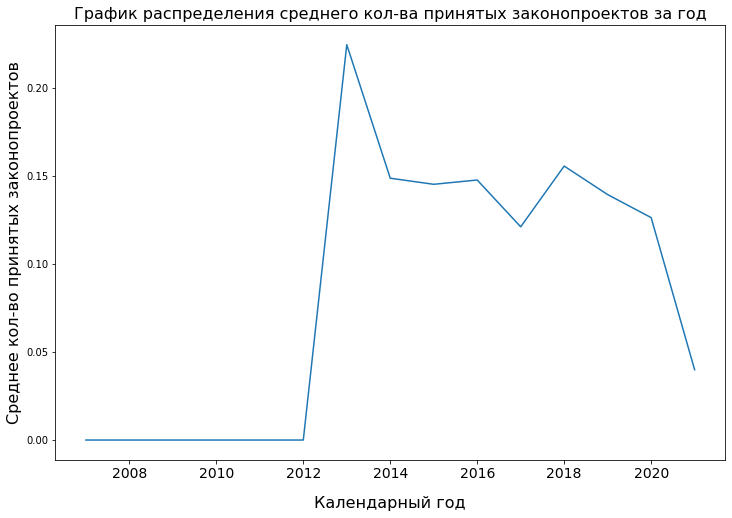

In [ ]:
plt.figure(figsize=(12,8))
new_data.groupby('year')['passed'].mean().plot()
plt.title('График распределения среднего кол-ва принятых законопроектов за год', fontsize = 16)
plt.xlabel('Календарный год', fontsize = 16,labelpad=15)
plt.xticks( fontsize = 14)
plt.ylabel('Среднее кол-во принятых законопроектов', fontsize = 16, )
plt.show()

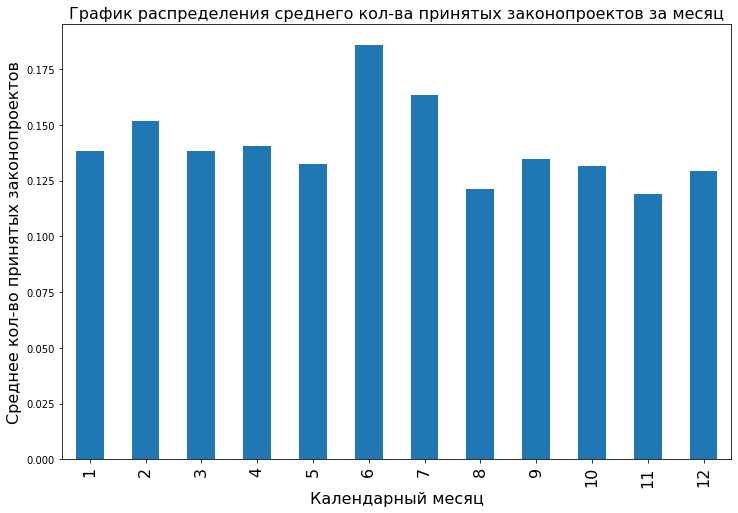

In [ ]:
plt.figure(figsize=(12,8))
new_data.groupby('month')['passed'].mean().plot(kind= 'bar')
plt.title('График распределения среднего кол-ва принятых законопроектов за месяц', fontsize = 16)
plt.xlabel('Календарный месяц', fontsize = 16)
plt.xticks( fontsize = 16)
plt.ylabel('Среднее кол-во принятых законопроектов', fontsize = 16)
plt.show()

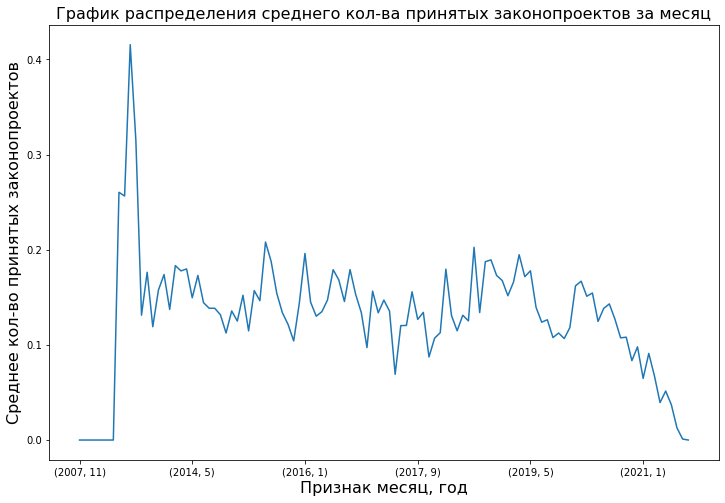

In [ ]:
plt.figure(figsize=(12,8))
new_data.groupby(['year', 'month'])['passed'].mean().plot()
plt.title('График распределения среднего кол-ва принятых законопроектов за месяц',fontsize = 16)
plt.xlabel('Признак месяц, год', fontsize = 16)
plt.ylabel('Среднее кол-во принятых законопроектов', fontsize = 16)
plt.show()

In [ ]:
new_data['sex_relation_add_resp'] = new_data.apply(lambda x: str(x['sex_added_by']) +'_' +  str(x['sex_response']), axis =1)


In [ ]:
map_dict = {'-1_1' : 'Неизвестно_мужчина', '-1_0' : 'Неизвестно_женщина', '-1_-1' : 'Неизвестно_Неизвестно', '0_1' : 'Женщина_мужчина', '0_0' : 'Женщина_женщина', '0_-1' : 'Женщина_неизвестно', '1_1' : 'Мужчина_мужчина', '1_0' : 'Мужчина_женщина', '1_-1' : 'Мужчина_неизвестно'}
new_data['sex_relation_add_resp'] = new_data['sex_relation_add_resp'].map(map_dict)

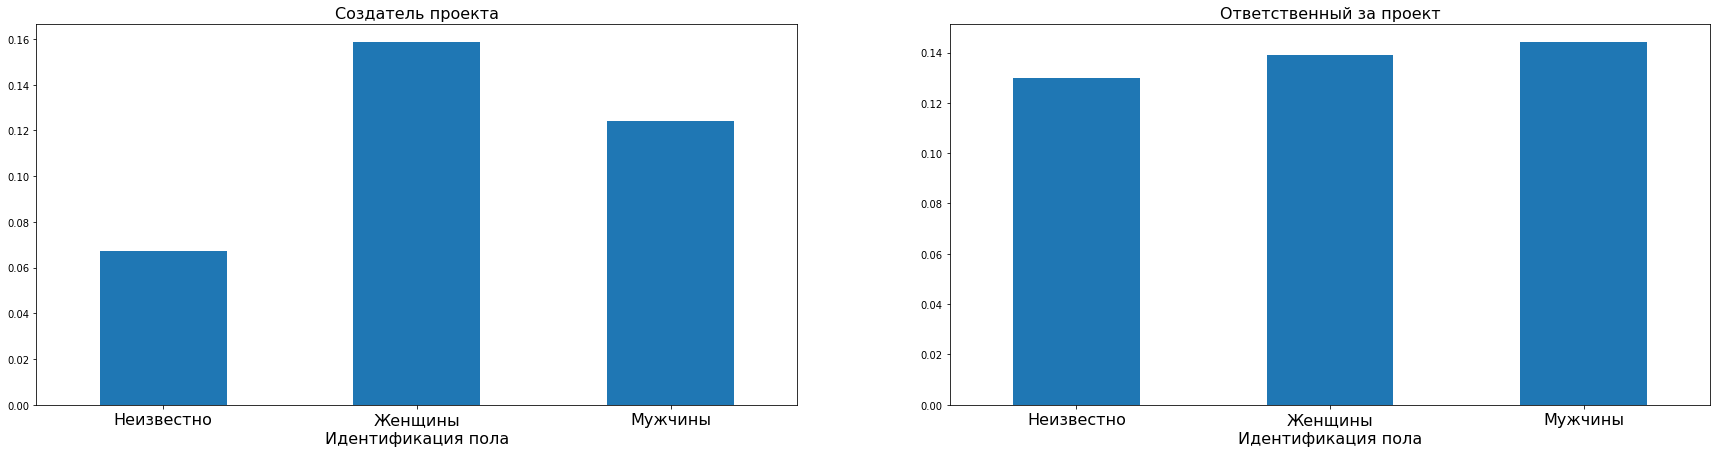

In [ ]:
fig, axes = plt.subplots(1,2)
new_data.groupby('sex_added_by')['passed'].mean().plot(kind = 'bar', ax = axes[0], figsize = (30,7))
new_data.groupby('sex_response')['passed'].mean().plot(kind = 'bar', ax = axes[1], figsize = (30,7))
axes[0].set_xticklabels(["Неизвестно", "Женщины", "Мужчины"], rotation = 0, fontsize = 16)
axes[1].set_xticklabels(["Неизвестно", "Женщины", "Мужчины"], rotation = 0, fontsize = 16)
axes[0].set_xlabel('Идентификация пола', fontsize = 16)
axes[1].set_xlabel('Идентификация пола', fontsize = 16)
axes[0].set_title('Создатель проекта', fontsize = 16)
axes[1].set_title('Ответственный за проект', fontsize = 16);

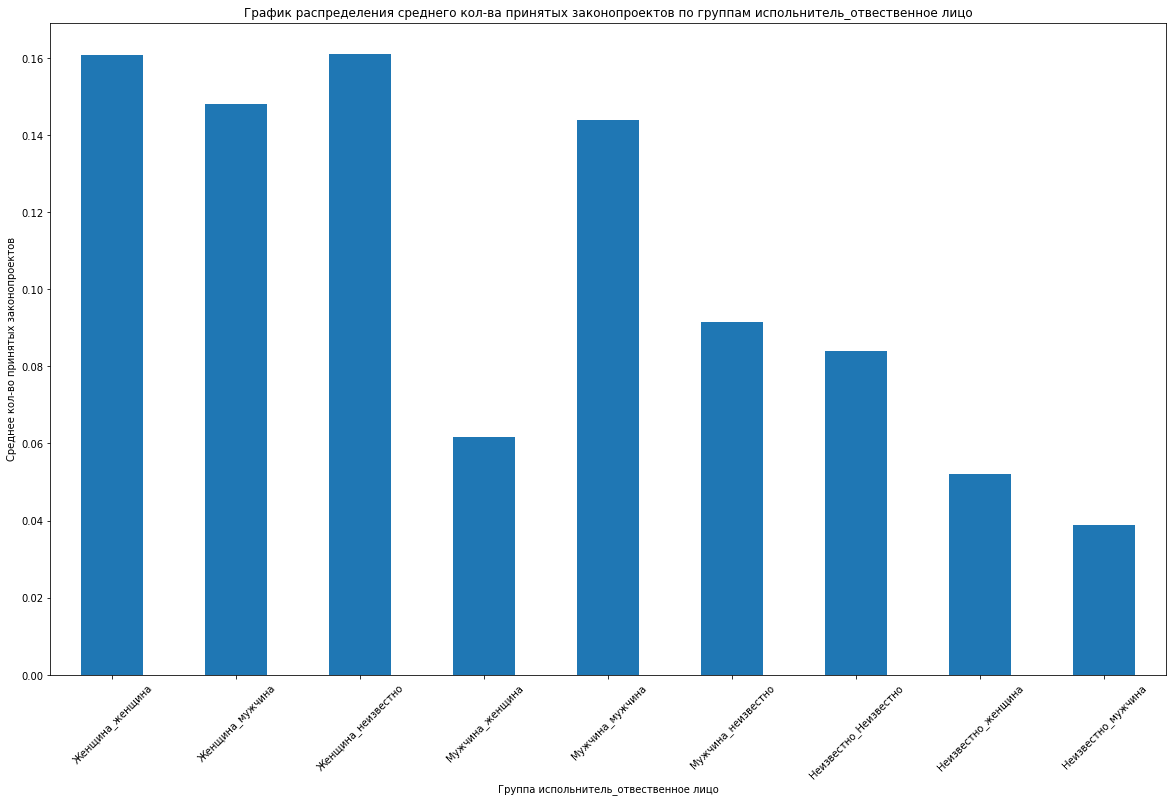

In [ ]:
plt.figure(figsize=(12,8))
new_data.groupby('sex_relation_add_resp')['passed'].mean().plot(kind = 'bar', figsize = (20, 12))
plt.title('График распределения среднего кол-ва принятых законопроектов по группам испольнитель_отвественное лицо')
plt.xlabel('Группа испольнитель_отвественное лицо')
plt.xticks(rotation = 45)
plt.ylabel('Среднее кол-во принятых законопроектов')
plt.show()

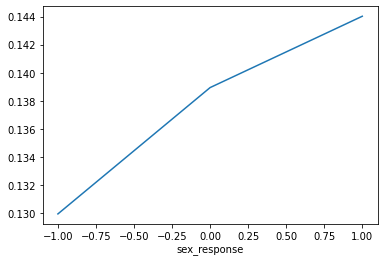

In [ ]:
new_data.groupby('sex_response')['passed'].mean().plot()

Создадим признак проверяющий совпадает ли отвественного лицо и исполнитель.

In [ ]:
new_data['is_add_equal_response'] = new_data.apply(lambda x: 1 if x['responsible'] == x['added_by'] else 0, axis = 1)
new_data['is_add_equal_response'] = new_data.apply(lambda x: -1 if (x['is_add_equal_response'])&(x['responsible'] == 'Нет ответственного')  else x['is_add_equal_response'], axis = 1)
new_data['is_add_equal_response'].value_counts()

0    43413
1    41004
Name: is_add_equal_response, dtype: int64

In [ ]:
new_data.groupby('is_add_equal_response')['passed'].mean()

is_add_equal_response
0    0.133283
1    0.148244
Name: passed, dtype: float64

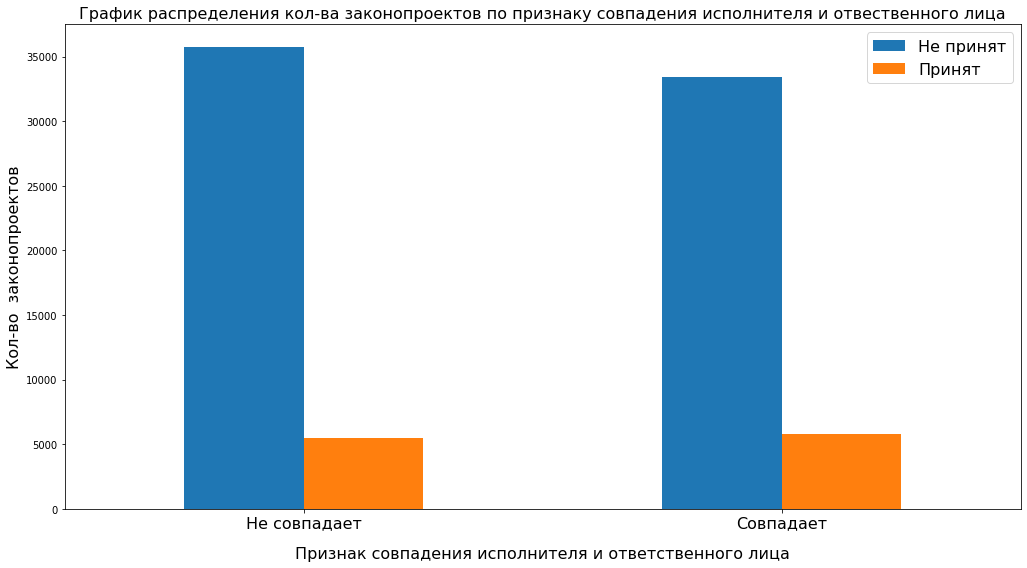

In [ ]:
fig, ax = plt.subplots()
pd.crosstab(new_data['is_add_equal_response'], new_data['passed']).plot(kind = 'bar', figsize = (15,8), ax = ax);
ax.set_title('График распределения кол-ва законопроектов по признаку совпадения исполнителя и отвественного лица', fontsize = 16)
ax.set_xlabel('Признак совпадения исполнителя и ответственного лица', fontsize = 16, labelpad=15,)
ax.set_ylabel('Кол-во  законопроектов',fontsize = 16)
ax.legend(["Не принят", "Принят"], fontsize = 16)
ax.set_xticklabels(['Не совпадает','Совпадает'], rotation = 0, fontsize = 16)
plt.tight_layout()
plt.show();


Text(0.5, 0, 'Совпадает ли исполнитель и ответственное лицо')

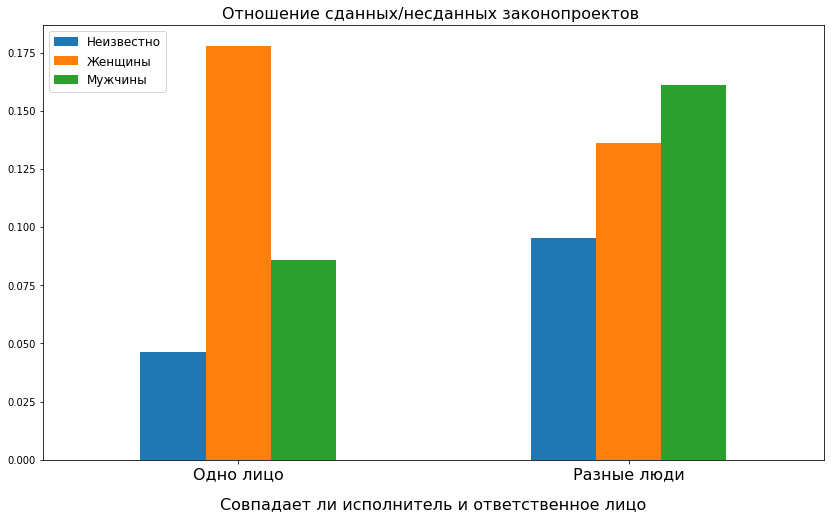

In [ ]:
fig, ax = plt.subplots()
pd.crosstab(new_data['is_add_equal_response'],new_data['sex_added_by'], values = new_data['passed'], aggfunc = 'mean').plot(kind = 'bar', ax = ax, figsize = (14, 8))
ax.legend(["Неизвестно", "Женщины", "Мужчины"], fontsize = 12)
ax.set_title('Отношение сданных/несданных законопроектов ', fontsize = 16)
ax.set_xticklabels(['Одно лицо','Разные люди'], rotation = 0, fontsize = 16)
ax.set_xlabel('Совпадает ли исполнитель и ответственное лицо', fontsize = 16, labelpad = 15)


Text(0.5, 0, 'Группа соотношения полов исполнитель и ответственное лицо')

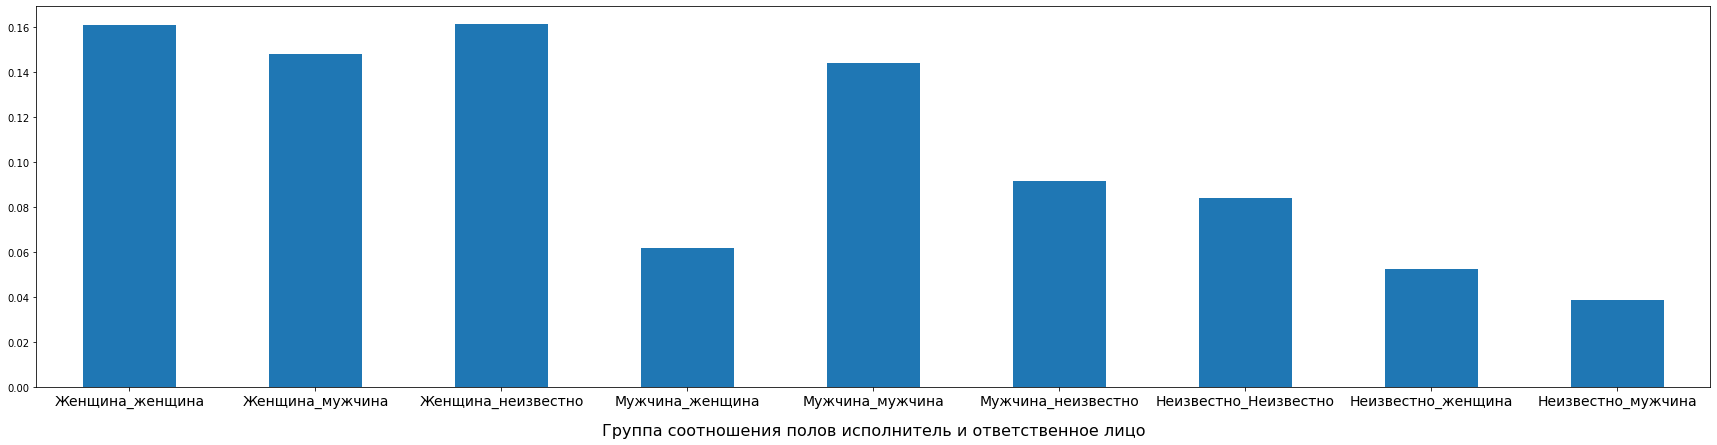

In [ ]:
fig, ax = plt.subplots()
new_data.groupby('sex_relation_add_resp')['passed'].mean().plot(kind = 'bar',figsize = (30, 7))
plt.xticks(rotation = 0,  fontsize = 14)
ax.set_xlabel('Группа соотношения полов исполнитель и ответственное лицо', fontsize = 16, labelpad = 15)



In [ ]:
pd.crosstab(new_data['sex_added_by'],new_data['sex_response'], margins=True, margins_name='Total_count')

sex_response,-1,0,1,Total_count
sex_added_by,,,,
-1,658,267,267,1192
0,3483,31188,7864,42535
1,2025,8487,30178,40690
Total_count,6166,39942,38309,84417


In [ ]:
train = new_data.loc[new_data['passed'].notnull(), :].drop(['publication_date','id','act_title'], axis = 1)
test = new_data.loc[new_data['passed'].isna(), :].drop(['publication_date','act_title'], axis = 1)
X, y = train.drop('passed', axis =1), train['passed']
numeric_col = X.dtypes[X.dtypes == float].index
numeric_col = [x for x in numeric_col if x != 'passed']
cat_col = [x for x in X.columns if x not in numeric_col]

Приступим к построению модели с помощью кросс-валидации тренировочной выборки по 5 фолдам.

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
clf = CatBoostClassifier(cat_features=cat_col, verbose = 100)
cv = StratifiedShuffleSplit(n_splits=3, test_size = 0.3)

score = cross_val_score(clf, X, y, cv = cv, scoring = 'roc_auc', )
print(score.mean())

Learning rate set to 0.057593
0:	learn: 0.6458045	total: 268ms	remaining: 4m 27s
100:	learn: 0.2457539	total: 15.9s	remaining: 2m 21s
200:	learn: 0.2381469	total: 32.5s	remaining: 2m 9s
300:	learn: 0.2332406	total: 49.3s	remaining: 1m 54s
400:	learn: 0.2295279	total: 1m 6s	remaining: 1m 38s
500:	learn: 0.2254268	total: 1m 23s	remaining: 1m 23s
600:	learn: 0.2221345	total: 1m 40s	remaining: 1m 6s
700:	learn: 0.2186712	total: 1m 58s	remaining: 50.4s
800:	learn: 0.2158103	total: 2m 15s	remaining: 33.6s
900:	learn: 0.2132755	total: 2m 32s	remaining: 16.8s
999:	learn: 0.2107593	total: 2m 49s	remaining: 0us
Learning rate set to 0.057593
0:	learn: 0.6449784	total: 132ms	remaining: 2m 11s
100:	learn: 0.2461214	total: 15.2s	remaining: 2m 15s
200:	learn: 0.2393286	total: 31.6s	remaining: 2m 5s
300:	learn: 0.2347755	total: 48.3s	remaining: 1m 52s
400:	learn: 0.2307364	total: 1m 5s	remaining: 1m 37s
500:	learn: 0.2272914	total: 1m 22s	remaining: 1m 21s
600:	learn: 0.2241370	total: 1m 39s	remaining

In [ ]:
from sklearn.metrics import roc_auc_score
estimator = clf.fit(X, y)


Learning rate set to 0.067068
0:	learn: 0.6370491	total: 223ms	remaining: 3m 42s
100:	learn: 0.2365938	total: 21.5s	remaining: 3m 11s
200:	learn: 0.2298982	total: 44.7s	remaining: 2m 57s
300:	learn: 0.2257716	total: 1m 8s	remaining: 2m 38s
400:	learn: 0.2222621	total: 1m 32s	remaining: 2m 17s
500:	learn: 0.2191287	total: 1m 55s	remaining: 1m 55s
600:	learn: 0.2164153	total: 2m 19s	remaining: 1m 32s
700:	learn: 0.2135611	total: 2m 43s	remaining: 1m 9s
800:	learn: 0.2111758	total: 3m 7s	remaining: 46.6s
900:	learn: 0.2089040	total: 3m 31s	remaining: 23.2s
999:	learn: 0.2068217	total: 3m 55s	remaining: 0us


Посмотрим какие признаки модель считает самыми важными, а от каких можно избавиться

In [ ]:
pd.DataFrame({'feature_importance': estimator.get_feature_importance(),
              'feature_names': X.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)

,feature_importance,feature_names
7,28.349980,added_by
8,12.461097,responsible
18,10.587847,year
0,7.928444,developer
6,5.870703,regulatory_impact
21,5.834971,mean_year_month
20,5.814817,year_month
2,4.856764,views_num
11,3.942790,mineco_solution
1,3.275215,okved_list


И наконец сделаем предсказание нашей моделе для тестовых данных. Поскольку оценочной метриков у нас является ROC_AUC нам потребуются в качестве ответа не номера классов, а вероятности классов.

In [ ]:
predictions = estimator.predict_proba(test.drop(['passed','id'], axis =1))
test['passed'] = predictions[:,1]

In [ ]:
sub_data = pd.DataFrame(test[['id','passed']])
sub_data.to_csv('var5.csv', index=False)